In [1]:
import pandas as pd
import numpy as np
import gensim
import pymorphy2
from nltk.corpus import stopwords
from gensim.models import FastText
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree#, inconsistent, maxRstat
from scipy.cluster.hierarchy import fcluster
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Отзывы из Яндекс.Карты
df = pd.read_csv('data_yamap_reviews.csv', delimiter = '\t')

In [3]:
df.head()

,id,object_id,user_name,user_grade,review_date_raw,review_body,review_like,review_dislike,review_stars,review_ts,ts,load_number
0,693,1326148544,Максим Р.,Знаток города 9 уровня,2020-07-10T07:02:11.323Z,Хороший офис,NaN,1.0,5,2020-07-10 07:02:11,2020-09-29 15:16:37.392349,2
1,1312,209460992346,Наталья П.,Знаток города 2 уровня,2018-12-22T11:15:27.205Z,Оценка хорошо!,NaN,3.0,5,2018-12-22 11:15:27,2020-09-29 15:22:49.504607,2
2,1452,175602635515,Роман. Za-rom.,Знаток города 4 уровня,2020-02-14T18:35:51.421Z,Все устраивает,1.0,NaN,5,2020-02-14 18:35:51,2020-09-29 15:24:01.42007,2
3,3036,1030303710,Яков Н.,Знаток города 2 уровня,2019-12-24T12:01:59.566Z,На уровне),3.0,NaN,5,2019-12-24 12:01:59,2020-09-29 15:39:46.763618,2
4,4762,1340928287,Ilya Guralnik,Знаток города 11 уровня,2020-08-27T07:55:00.495Z,Все хорошо,6.0,NaN,5,2020-08-27 07:55:00,2020-09-29 15:55:37.796665,2


In [4]:
df.shape

(15450, 12)

## Предобработка данных

In [5]:
df = df.drop_duplicates()
df= df.dropna(axis='index', how='any', subset=['review_body'])
#df = df.reset_index()

In [6]:
#Токенизация
tokens = df['review_body'].apply(lambda x: gensim.utils.simple_preprocess(x, min_len=2, max_len=60))
tokens

0                                          [хороший, офис]
1                                         [оценка, хорошо]
2                                        [все, устраивает]
3                                             [на, уровне]
4                                            [все, хорошо]
                               ...                        
15445                                                 [ок]
15446    [всё, хорошо, только, нет, стульев, для, клиен...
15447                       [хороший, курс, обмена, валют]
15448                                     [отличный, банк]
15449                       [большой, процент, на, кредит]
Name: review_body, Length: 15450, dtype: object

In [7]:
#Нормализация
morph = pymorphy2.MorphAnalyzer()
tokens_norm = tokens.apply(lambda x: [morph.parse(i)[0].normal_form for i in x])
tokens_norm

0                                       [хороший, офис]
1                                      [оценка, хорошо]
2                                    [весь, устраивать]
3                                         [на, уровень]
4                                        [весь, хорошо]
                              ...                      
15445                                              [ок]
15446    [весь, хорошо, только, нет, стул, для, клиент]
15447                    [хороший, курс, обмен, валюта]
15448                                  [отличный, банк]
15449                    [большой, процент, на, кредит]
Name: review_body, Length: 15450, dtype: object

In [8]:
text_norm = tokens_norm.apply(lambda x: ' '.join(x))
df['tokens_norm'] = tokens_norm
df['text_norm'] = text_norm

In [9]:
# Удаляем стоп-слова
stop_words = stopwords.words('russian')
stop_words.extend(['это', 'весь', 'quot', 'который', 'ещё', 'свой', 'br', 'ваш', 'очень', 'почему', 'хотя', 'самый', 'сразу', 'вообще', 'банк','как','не','очень','это','на','банка','весь','по','что','но','быть','ни','один','всегда','нет','из','самый'])
# Стоп-слова эмоциональной окраски
stop_words.extend(['хорошо',
'хороший',
'отличный',
'неплохой',
'порядочный',
'прекрасный',
'недурной',
'превосходный',
'приличный',
'великолепный',
'замечательный',
'отменный',
'отличной',
'плохой',
'плохо',
'дурной',
'скверный',
'нехороший',
'неважный',
'хреновый',
'отвратительный',
'худший',
'ужасный',
'отвратительно',
'плохое',
'дурной '])

In [10]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

In [11]:
df['tokens_norm_nosw'] = remove_stopwords(tokens_norm)
df['text_norm_nosw'] = df['tokens_norm_nosw'].apply(lambda x: ' '.join(x))

In [12]:
df[['review_body', 'text_norm', 'tokens_norm_nosw', 'text_norm_nosw']].head()

,review_body,text_norm,tokens_norm_nosw,text_norm_nosw
0,Хороший офис,хороший офис,[офис],офис
1,Оценка хорошо!,оценка хорошо,[оценка],оценка
2,Все устраивает,весь устраивать,[устраивать],устраивать
3,На уровне),на уровень,[уровень],уровень
4,Все хорошо,весь хорошо,[],


In [13]:
df = df[df['text_norm_nosw']!='']
df = df.reset_index()

In [14]:
df.shape

(15180, 17)

In [15]:
df[['review_body', 'text_norm', 'tokens_norm_nosw', 'text_norm_nosw']].head()

,review_body,text_norm,tokens_norm_nosw,text_norm_nosw
0,Хороший офис,хороший офис,[офис],офис
1,Оценка хорошо!,оценка хорошо,[оценка],оценка
2,Все устраивает,весь устраивать,[устраивать],устраивать
3,На уровне),на уровень,[уровень],уровень
4,"Это не банк, это ПРОФАНАЦИЯ ! НИКОМУ НЕ СОВЕТУ...",это не банк это профанация никто не советовать...,"[профанация, никто, советовать, перечислить, д...",профанация никто советовать перечислить деньга...


## FastText

In [16]:
#Модель обучается на полных отзывах, применяется к отзывам после удаления стоп-слов
model = FastText(sg = 1, size=300, window=10, min_count=50, min_n = 3, max_n = 3, workers = 16)
model.build_vocab(df['tokens_norm'])

In [17]:
from gensim.test.utils import get_tmpfile

from gensim.models.callbacks import CallbackAny2Vec

class EpochLogger(CallbackAny2Vec):

    '''Callback to log information about training'''

    def __init__(self):

        self.epoch = 0


    def on_epoch_begin(self, model):

        print("Epoch #{} start".format(self.epoch))


    def on_epoch_end(self, model):

        print("Epoch #{} end".format(self.epoch))

        self.epoch += 1

In [18]:
epoch_logger = EpochLogger()
model.train(sentences=df['tokens_norm'], total_examples=len(df['tokens_norm']), epochs=10, callbacks=[epoch_logger])

Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end
Epoch #8 start
Epoch #8 end
Epoch #9 start
Epoch #9 end


In [19]:
#Самые близкие слова к слову "сотрудник"
model.most_similar('сотрудник')

[('сотрудница', 0.7070389986038208),
 ('работник', 0.7039225101470947),
 ('персонал', 0.6518454551696777),
 ('коллектив', 0.5368092656135559),
 ('девочка', 0.507668137550354),
 ('консультант', 0.49229300022125244),
 ('менеджер', 0.4744637608528137),
 ('операционист', 0.4724774956703186),
 ('посетитель', 0.465565025806427),
 ('специалист', 0.4651201367378235)]

In [20]:
#Средний вектор для каждого отзыва
vectors = pd.DataFrame(columns = ['vector']) 
for i in range(len(df['tokens_norm'])):
    vm = np.mean(model[df.loc[i, 'tokens_norm_nosw']], axis = 0)
    vectors.loc[i, 'vector'] = vm

vectors

,vector
0,"[-0.03177598, 0.118175425, 0.26784524, 0.04303..."
1,"[-0.022174556, -0.21036264, 0.008791209, 0.222..."
2,"[-0.0840267, -0.12253077, 0.25890243, 0.044862..."
3,"[-0.17052773, -0.107632354, 0.017327704, 0.340..."
4,"[-0.007602102, -0.09654741, 0.029970901, 0.052..."
...,...
15175,"[-0.17416918, -0.0986372, 0.108343676, 0.02747..."
15176,"[-0.020399377, -0.03759092, 0.058643933, 0.041..."
15177,"[0.0032656938, -0.07856156, 0.050420925, 0.067..."
15178,"[-0.049716603, -0.12660353, 0.108441226, -0.10..."


In [21]:
df['vector'] = vectors['vector']
v = df['vector']
v = pd.DataFrame(v)['vector'].apply(pd.Series)
hc = linkage(v, 'ward')#Матрица близости для иерархической кластеризации
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(v)#t-SNE представление

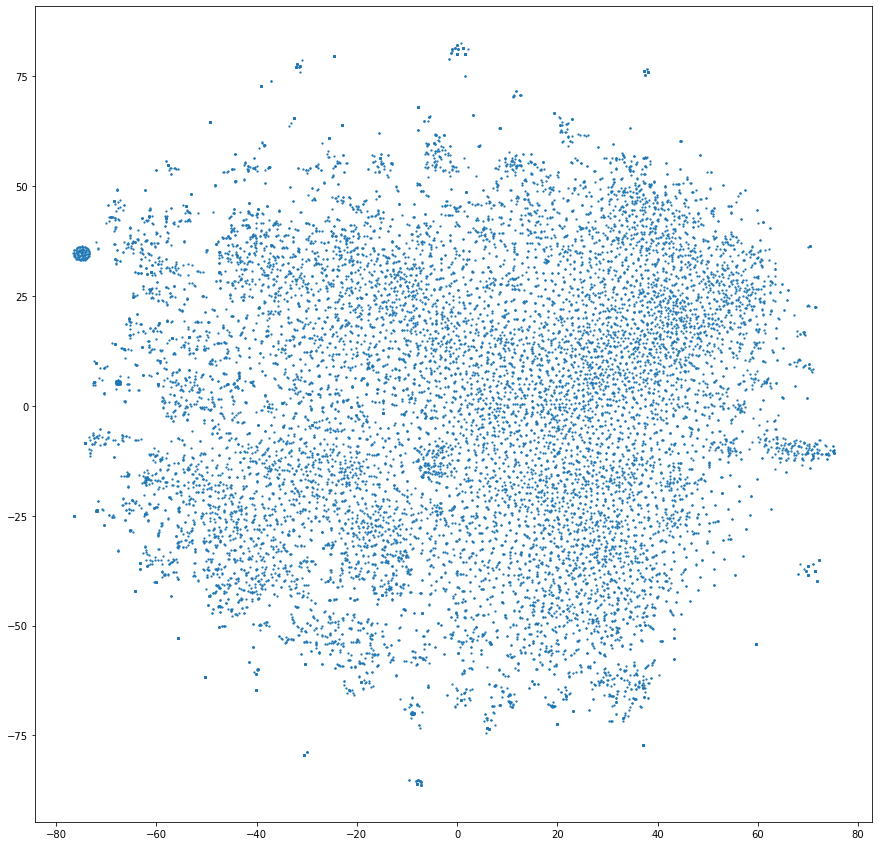

In [22]:
#Строим график t-SNE
tdf = pd.DataFrame()
tdf['x'] = X_embedded[:,0]
tdf['y'] = X_embedded[:,1]
plt.ioff()
plt.figure(figsize=(15, 15))
plt.scatter(tdf.x, tdf.y, cmap='prism', s=1.5) 
plt.savefig('tsne')
plt.show()
plt.close()

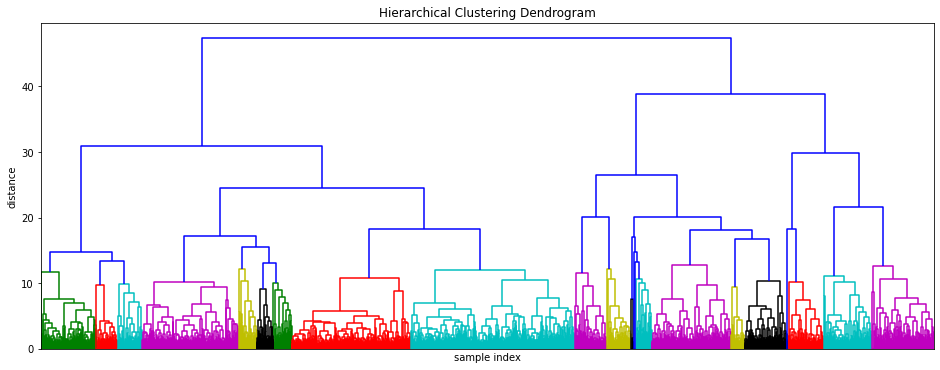

In [23]:
#Строим дерево на основе матрицы близости
plt.ioff()
plt.figure(figsize=(16, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
        hc,
        leaf_rotation=90.,
        leaf_font_size=8.,
        truncate_mode='level',
        p=16,
        color_threshold=13,
        no_labels=True
    )
plt.savefig('h_tree', bbox_inches='tight')
plt.show()
plt.close()

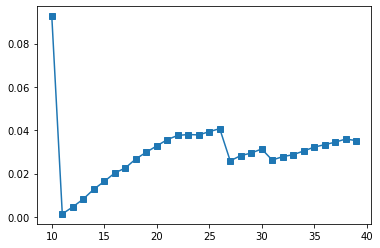

In [24]:
#Рассчитываем значение силуэта для моделей с числом кластеров от 10 до 40
sils = []
for k in range(10, 40):
    clusts = fcluster(hc, k, criterion='maxclust')
    sils.append(metrics.silhouette_score(v , clusts ))

plt.plot(range(10, 40), sils, marker='s');
plt.show()

In [25]:
sils

[0.09262332,
 0.0013887667,
 0.0046107704,
 0.008252404,
 0.012769765,
 0.016390286,
 0.020267006,
 0.022578789,
 0.026737424,
 0.029855946,
 0.03278228,
 0.03566478,
 0.037631687,
 0.038023062,
 0.03785325,
 0.03936138,
 0.040731966,
 0.025873883,
 0.028313855,
 0.029465413,
 0.03137125,
 0.026232745,
 0.027831476,
 0.02871852,
 0.030439898,
 0.03219874,
 0.033359863,
 0.03448599,
 0.03594377,
 0.035242055]

In [26]:
#Оптимальное число кластеров - 30
clusters_30 = fcluster(hc, 30, criterion='maxclust')
df['clusters30'] = clusters_30

In [27]:
df['clusters30'].value_counts()

12    2401
10    2101
11    1821
5     1526
30     807
2      705
24     670
21     581
28     563
22     550
26     481
20     372
9      317
4      302
14     287
16     279
3      238
7      194
8      181
23     157
25     113
29     110
18      94
13      87
17      60
19      47
1       46
27      38
6       32
15      20
Name: clusters30, dtype: int64

Одна мысль клиентом может быть выражена нескольки формулиовками. Так как комментарии довольно короткие, каждая такая формулировка выделяется в отдельный кластер. Алгоритмом было выделено 30 кластеров, но по смыслу они схлопываются в 10 основных:
 1. Скорость обслуживания
 2. Распложение, удобство
 3. Помещение
 4. Парковка
 5. Общая оценка
 6. Обслуживание и персонал
 7. Обмен валют
 8. Банкоматы
 9. Банковские продукты
 10. Прочее

In [28]:
df_result = pd.read_csv('yamap_result.csv', delimiter = ';')

In [29]:
df_result[df_result['Бизнес-кластер']=='Скорость обслуживания']

,id,review_body,Бизнес-кластер
6,8345,нет очередей,Скорость обслуживания
9,10200,Очереди.,Скорость обслуживания
11,708,Все приходится долго ждать,Скорость обслуживания
12,709,Большие очереди,Скорость обслуживания
13,2865,Долго ждать,Скорость обслуживания
...,...,...,...
15165,15609,Очереди почти всегда,Скорость обслуживания
15166,15610,Устанете ждать,Скорость обслуживания
15170,15614,"Грамотно, оперативно, профессионально.",Скорость обслуживания
15172,15617,Медленное обслуживание,Скорость обслуживания


In [30]:
df_result[df_result['Бизнес-кластер']=='Обслуживание и персонал']

,id,review_body,Бизнес-кластер
1,1312,Оценка хорошо!,Обслуживание и персонал
3,3036,На уровне),Обслуживание и персонал
17,3884,Обслуживание на уровне,Обслуживание и персонал
58,195,Очень хороший офис. Персонал компитентен и отз...,Обслуживание и персонал
61,196,Газпромбанк. Будьте очень осторожны и внимател...,Обслуживание и персонал
...,...,...,...
15159,15600,Разъяснили все вопросы,Обслуживание и персонал
15163,15606,Хорошее обслуживание,Обслуживание и персонал
15168,15612,Хорошее обслуживание,Обслуживание и персонал
15171,15615,Хороший персонал,Обслуживание и персонал


In [31]:
df_result[df_result['Бизнес-кластер']=='Обмен валют']

,id,review_body,Бизнес-кластер
564,699,Удивительно удачные курсы валют.,Обмен валют
573,715,Удивительно приятный курс валют.,Обмен валют
973,1108,"Могу сказать только одно, что тут самый выгодн...",Обмен валют
1105,1236,Хороший курс обмена валют,Обмен валют
1174,1433,Обменял валюту все ок,Обмен валют
...,...,...,...
14547,14963,"Нету покупки валют, как с этим делом у них все...",Обмен валют
14564,14982,Даже обменника нет,Обмен валют
14842,15273,"Отделение банка, правда нет обмена валют.",Обмен валют
15152,15591,Не меняют валюту. Ставлю минус,Обмен валют
